### Preliminaries

In [3]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit1,fit2,params

### Load the data

In [5]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],
                                      target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [6]:
y = np.ma.dstack([Y_all_mask['subject'][i] for i in range(1,50)])

In [11]:
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')

In [35]:
descriptors = [ph.split('/')[0].lower() for ph in perceptual_headers[6:]]

In [20]:
y2 = np.ma.dstack((y,y))
y2.shape

(814, 21, 98)

In [76]:
CIDs = loading.get_CIDs('training')
data = np.ma.zeros((49,len(CIDs),21,4,2),dtype='float')
data.mask +=1
for line in perceptual_obs_data:
    CID_index = CIDs.index(int(line[0]))
    subject = int(line[5])
    is_replicate = line[2]
    dilution_index = ['1/10','1/1,000','1/100,000','1/10,000,000'].index(line[4])
    for i,value in enumerate(line[6:]):
        indices = subject-1,CID_index,i,dilution_index,int(is_replicate)
        if value != 'NaN':
            if (i==0 and dilution_index==1) or (i>0 and line[3]=='high'):
                data[indices] = float(value)
# Indices are:
#  subject number (0-48)
#  CID index
#  descriptor number (0-20)
#  dilution rank (1/10=0, 1/1000=1, 1/100000=2, 1/1000000=3)
#  replicate (original=0, replicate=1)
# Data is masked so locations with no data are not included in statistics on this array.  

In [100]:
only_replicates = data.copy()
only_replicates.mask[:,:,:,:,0] = data.mask[:,:,:,:,1]

r_rep = {_:np.zeros(21) for _ in ['mean','std']}
for desc in range(21):
    orig_mean = only_replicates[:,:,desc,1,0].mean(axis=0).ravel()
    rep_mean = only_replicates[:,:,desc,1,1].mean(axis=0).ravel()
    orig_std = only_replicates[:,:,desc,1,0].std(axis=0).ravel()
    rep_std = only_replicates[:,:,desc,1,1].std(axis=0).ravel()
    r_rep['mean'][desc] = np.corrcoef(orig_mean,rep_mean)[0,1]
    r_rep['std'][desc] = np.corrcoef(orig_std,rep_std)[0,1]

In [101]:
# Taken from previous fits.  
best = {}
best['mean'] = np.array([0.70097375,  0.66613775,  0.60919667,  0.71083115,  0.72697513,
        0.41324559,  0.67517077,  0.35532091,  0.32683721,  0.5739374 ,
        0.4174755 ,  0.45235007,  0.17290684,  0.42151002,  0.48610618,
        0.3819078 ,  0.52868636,  0.33612901,  0.35745922,  0.51474916,
        0.64789066]) 
best['std'] = np.array([ 0.38      ,  0.4       ,  0.49785038,  0.63549459,  0.73547243,
        0.45797419,  0.5945972 ,  0.4086892 ,  0.40109547,  0.52394973,
        0.50651325,  0.61262666,  0.31698427,  0.44576133,  0.45793596,
        0.50874842,  0.47298217,  0.34315854,  0.3857553 ,  0.50038353,
        0.69402738])

In [102]:
'''
from sklearn.cross_validation import ShuffleSplit
n_splits = 100
rm = np.zeros((n_splits,21))
rs = np.zeros((n_splits,21))
shuff = ShuffleSplit(98,n_iter=n_splits,test_size=0.5,random_state=0)
for col in range(21):
    for i,(a,b) in enumerate(shuff):
        ma = np.ma.mean(y2[:,col,a],axis=1)
        mb = np.ma.mean(y2[:,col,b],axis=1)
        sa = np.ma.std(y2[:,col,a],axis=1)
        sb = np.ma.std(y2[:,col,b],axis=1)
        rm[i,col] = np.corrcoef(ma,mb)[0,1]
        rs[i,col] = np.corrcoef(sa,sb)[0,1]
''';

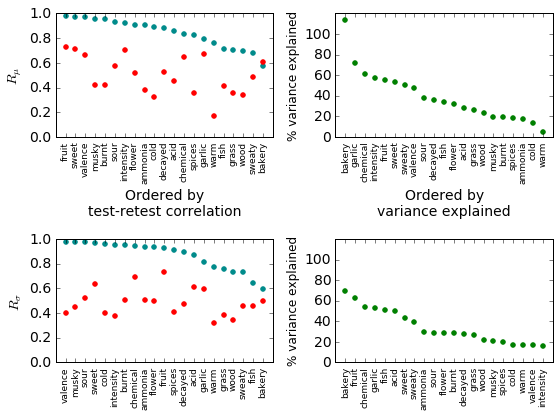

In [150]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(2,2,sharey=False,figsize=(8,6))

def plot_predictability(col):
    for row,stat in [(0,'mean'),(1,'std')]:
        if col==0:
            ax[row,col].scatter(range(1,22),r_rep[stat][order[stat]],color='darkcyan')
            ax[row,col].scatter(range(1,22),best[stat][order[stat]],color='r')
        elif col==1:
            ax[row,col].scatter(range(1,22),100*ratio[stat][order[stat]],color='g')
        ax[row,col].set_xlim(0,22)
        ax[row,col].set_xticks(range(1,22))
        ax[row,col].set_xticklabels(np.array(descriptors)[order[stat]], fontdict={'fontsize':9}, rotation=90)

order = {}
order['mean'] = np.argsort(r_rep['mean'])[::-1]
order['std'] = np.argsort(r_rep['std'])[::-1]
plot_predictability(0)

ratio = {}
ratio['mean'] = best['mean']**2 / r_rep['mean']**2 
ratio['std'] = best['std']**2 / r_rep['std']**2 
order['mean'] = np.argsort(ratio['mean'])[::-1]
order['std'] = np.argsort(ratio['std'])[::-1]
plot_predictability(1)

ax[0,0].set_ylabel(r'$R_\mu$')
ax[1,0].set_ylabel(r'$R_\sigma$')
for row in [0,1]:
    ax[row,1].set_ylabel('% variance explained',fontdict={'fontsize':12})
    ax[row,0].set_ylim(0,1)
    ax[row,1].set_yticks(range(0,105,20))    
    ax[row,1].set_yticklabels(range(0,105,20))    
    ax[row,1].set_ylim(0,120)  
ax[0,0].set_xlabel('Ordered by\ntest-retest correlation')
ax[0,1].set_xlabel('Ordered by\nvariance explained')
    
plt.tight_layout()

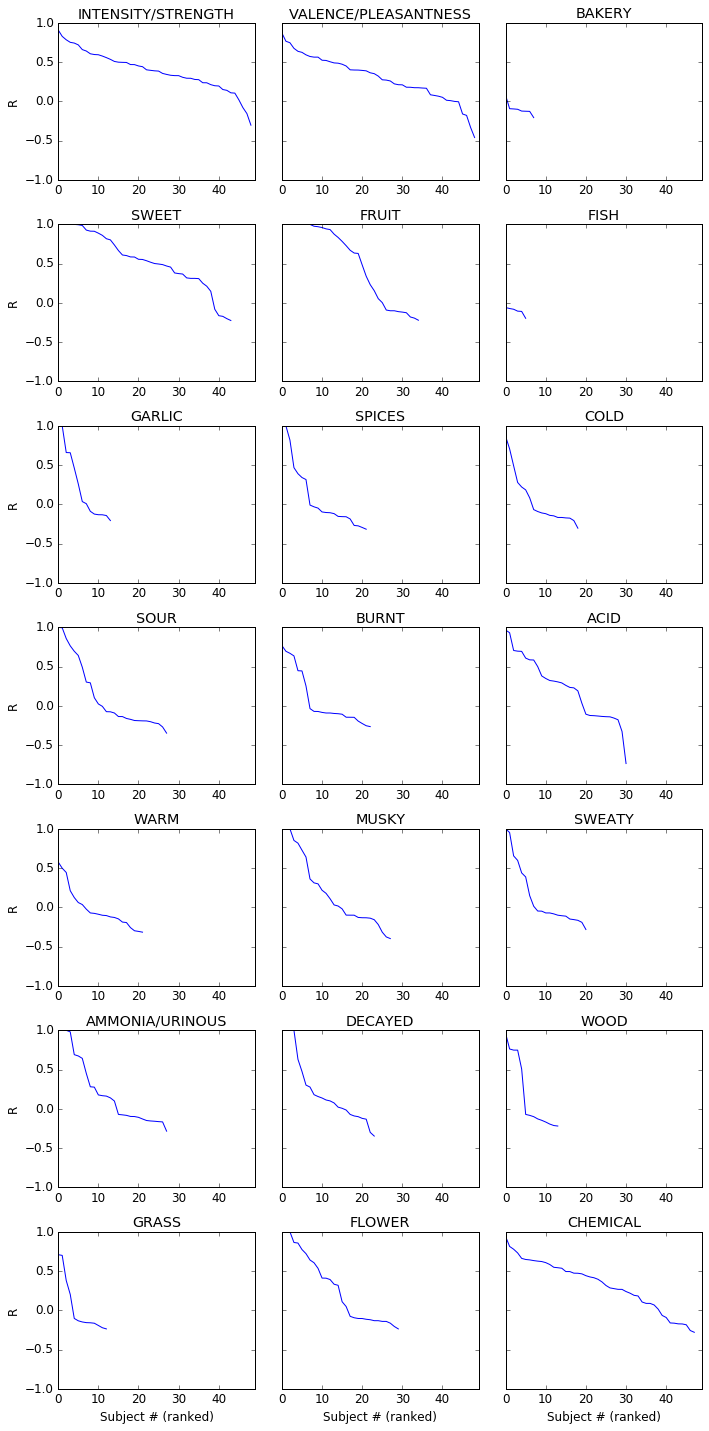

In [14]:
import sys
matplotlib.rcParams.update({'font.size': 12})
fig,axes = plt.subplots(7,3,sharey=True,figsize=(10,20))
ax = axes.flat
for desc in range(21):
    rs = []
    for subject in range(49):
        orig = only_replicates[subject,:,desc,1,0]
        rep = only_replicates[subject,:,desc,1,1]
        r = np.ma.corrcoef(orig,rep)[0,1]
        if r:
            rs.append(r)
        else:
            if orig.sum() and rep.sum():
                pass
                #print(orig)
                #print(rep)
                #print('=====================')
    ax[desc].plot(sorted(rs,reverse=True))
    ax[desc].set_xlim(0,49)
    ax[desc].set_ylim(-1,1)
    ax[desc].set_title(perceptual_headers[6:][desc])
    if desc % 3 == 0:
        ax[desc].set_ylabel('R')
    if desc >= 18:
        ax[desc].set_xlabel('Subject # (ranked)')
plt.tight_layout()

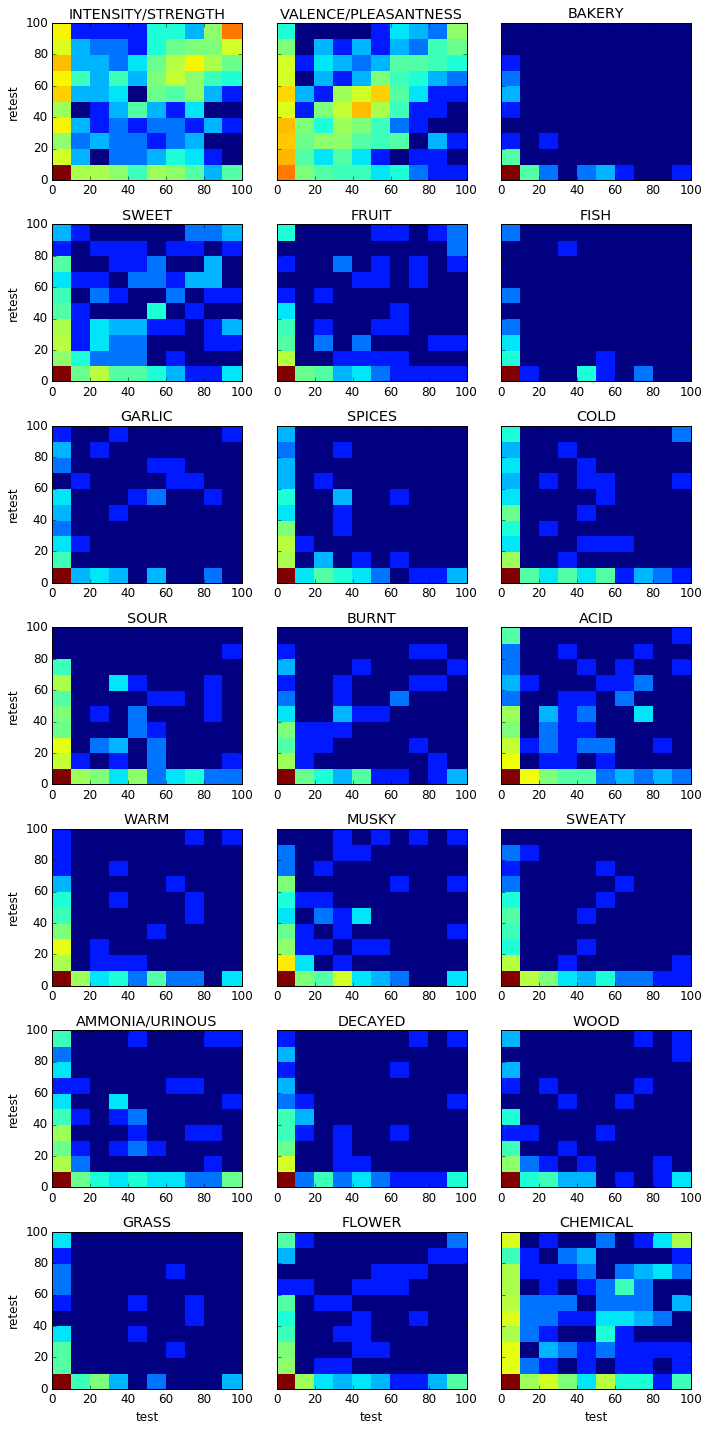

In [16]:
import sys
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 12})
fig,axes = plt.subplots(7,3,sharey=True,figsize=(10,20))
ax = axes.flat
for desc in range(21):
    orig = only_replicates[:,:,desc,1,0].ravel().filled()
    rep = only_replicates[:,:,desc,1,1].ravel().filled()
    xedges = np.linspace(-0.001,100.001,11)
    yedges = np.linspace(-0.001,100.001,11)
    H, xedges, yedges = np.histogram2d(rep, orig, bins=(xedges, yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax[desc].pcolormesh(X, Y, 1+H, norm=LogNorm(1,100))
    #ax[desc].set_aspect('equal')
    ax[desc].set_title(perceptual_headers[6:][desc])
    ax[desc].set_xlim(0,100)
    ax[desc].set_ylim(0,100)
    if desc % 3 == 0:
        ax[desc].set_ylabel('retest')
    if desc >= 18:
        ax[desc].set_xlabel('test')
plt.tight_layout()